# LSTM

1. Wprowadzenie do sieci LSTM
2. Import bibliotek
3. Baza danych
4. Wstępna analiza tekstu
5. Modele treningowe (poszukiwanie optymalnego rozwiązania)
6. Praca na modelu
7. Analiza sentymentu
8. Podsumowanie

1. Wprowadzenie do sieci LSTM

Long Short-Term Memory to ulepszona wersja rekurencyjnej sieci neuronowej zaprojektowanej przez Hochreitera & Schmidhubera. LSTM dobrze nadaje się do zadań przewidywania sekwencji i specjalizuje się w wychwytywaniu długoterminowych zależności. Jego zastosowania obejmują zadania obejmujące szeregi i sekwencje czasowe. Siła LSTM leży w jego zdolności do uchwycenia zależności kolejności kluczowych w rozwiązywaniu skomplikowanych problemów, takich jak tłumaczenie maszynowe i rozpoznawanie mowy.

Co to jest LSTM?

Tradycyjny RNN ma jeden ukryty stan, który jest przekazywany w czasie, co może utrudniać sieci nauczenie się długoterminowych zależności. LSTM rozwiązują ten problem, wprowadzając komórkę pamięci, która jest pojemnikiem mogącym przechowywać informacje przez dłuższy czas. Sieci LSTM potrafią uczyć się długoterminowych zależności w danych sekwencyjnych, co czyni je dobrze dostosowanymi do takich zadań, jak tłumaczenie języków, rozpoznawanie mowy i prognozowanie szeregów czasowych. LSTM można również stosować w połączeniu z innymi architekturami sieci neuronowych, takimi jak konwolucyjne sieci neuronowe (CNN) do analizy obrazu i wideo.

Komórka pamięci jest kontrolowana przez trzy bramki: bramkę wejściową, bramkę zapominania i bramkę wyjściową. Bramki te decydują, jakie informacje dodać, usunąć i wyprowadzić z komórki pamięci. Bramka wejściowa kontroluje, jakie informacje są dodawane do komórki pamięci. Bramka zapominania kontroluje, jakie informacje są usuwane z komórki pamięci. Bramka wyjściowa kontroluje, jakie informacje są wysyłane z komórki pamięci. Dzięki temu sieci LSTM mogą selektywnie zatrzymywać lub odrzucać informacje przepływające przez sieć, co pozwala im uczyć się długoterminowych zależności.

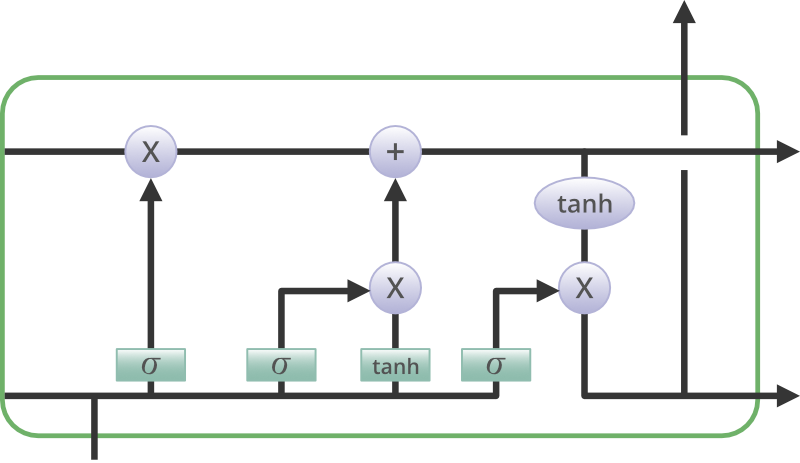



Dwukierunkowy LSTM

Dwukierunkowy LSTM (Bi LSTM/BLSTM) to rekurencyjna sieć neuronowa (RNN), która jest w stanie przetwarzać dane sekwencyjne zarówno w kierunku do przodu, jak i do tyłu. Dzięki temu Bi LSTM może uczyć się zależności o większym zasięgu w danych sekwencyjnych niż tradycyjne LSTM, które mogą przetwarzać dane sekwencyjne tylko w jednym kierunku.

2. Import bibliotek

In [1]:
import pandas as pd
import numpy as np


!pip install -q tensorflow
!pip install -q spacy
!python -m spacy download en_core_web_md -q
!pip install Wordcloud -q
!pip install accelerate -q
!pip install transformers -q
!pip install datasets -q

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS

from tqdm import tqdm
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score, roc_curve

from tensorflow.keras.layers import GRU, LSTM, SimpleRNN, Embedding, Dropout
from tensorflow.keras.layers import Activation, Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time

import en_core_web_sm

2023-12-27 08:46:00.260545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 08:46:00.264507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 08:46:00.267125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 08:46:00.294440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 08:46:02.655101: W tensorflow/compiler/tf2

In [2]:
!pip install -U accelerate==0.20.3 -q
import accelerate
!pip install transformers -q
import transformers

#!pip install accelerate -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 2.7 MB/s eta 0:00:00


3. Baza danych

Baza danych pochodzi z zasobów kaggle i znajduje się pod linkiem:
https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

Baza obejmuje 20 491 recenzje klientów dotyczących hoteli, z których skorzystali. Rating w skali 1 - 5 z dominacją 4 i 5.

In [3]:
# Dane umieściłam na google drive, skąd je pobieram

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/tripadvisor_hotel_reviews.csv'
row_data = pd.read_csv(path)
row_data

Mounted at /content/drive


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [4]:
# Zamieniam Rating na 3 klasy

row_data['Rating_class'] = row_data['Rating'].replace({5: 'Positive', 4: 'Positive', 3: 'Neutral',
                                                      2:'Negative', 1:'Negative'})
row_data

,Review,Rating,Rating_class
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


In [5]:
# Tworzę kopię danych

data = row_data.copy()
del data['Rating']

4. Wstępna analiza tekstu

Przechodze do analizy tekstu dotyczącej m.in identyfikacji każdej z 3 grup klientów, stworzenia WordCloud na podstawie wcześniej zdefiniowanej próbki.
Definiuję funkcję remove_stopwords w celu usunięcia słów takich jak 'the' czy 'and' oraz uruchamiam proces lematyzacji w celu ujednolicenia odmiany słów.

In [6]:
data.shape

(20491, 2)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        20491 non-null  object
 1   Rating_class  20491 non-null  object
dtypes: object(2)
memory usage: 320.3+ KB


In [8]:
data.groupby('Rating_class').nunique()

,Review
Rating_class,
Negative,3214
Neutral,2184
Positive,15093


<Axes: xlabel='Rating_class', ylabel='count'>

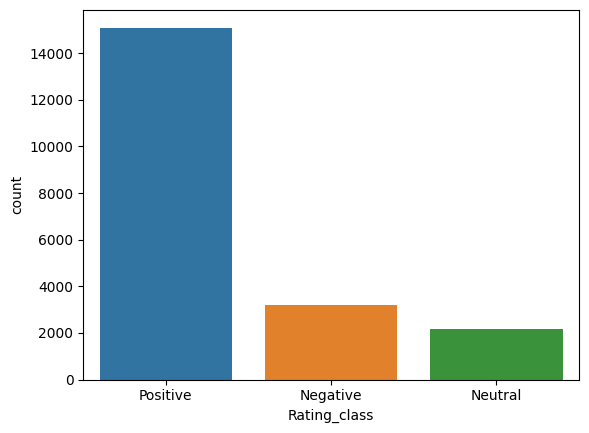

In [9]:
sns.countplot(x='Rating_class', data=data)

In [10]:
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.sample(10)

,Review,Rating_class
2400,way expectations booking hotel looked expedia ...,Negative
10073,"nice nice nice stayed ambassador nights, greet...",Positive
10453,barely passable read good reviews frommers pla...,Negative
3156,"heaven earth, husband spent 2 fabulous weeks m...",Positive
12747,great city stayed millenium hilton 29th decemb...,Positive
19482,"fantastic, going year, husband riu palace 7nig...",Positive
14311,"excellent hotel, hotel great bargain, staff fr...",Positive
14512,birthday meal havnt stayed hotel staying barce...,Positive
427,mixed experience travel frequently work pleasu...,Neutral
10008,langlois revisited just returned girlie weeken...,Positive


In [11]:
import spacy

nlp = spacy.load('en_core_web_md', disable=['ner', 'parser'])
nlp.add_pipe('sentencizer')

In [12]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

data['Review'] = data['Review'].apply(remove_stopwords)
data.sample(10)

,Review,Rating_class
13368,"poor service impressions great, arrival young ...",Negative
19473,nice lots maids/cleaners sticky fingers spent ...,Negative
164,great older hotel downtown location great espe...,Positive
13894,"fantastic hotel, recently returned 3 night bre...",Positive
4509,"especially art fan stay, loved hotel primarily...",Positive
313,"unique exceptional, loved stay, husband spent ...",Positive
18321,bargain weekend excellent stay quality hotel.t...,Positive
1662,"amazing getaway, day trip san francisco perfec...",Positive
19511,certainly worth money returned trip tortuga ba...,Negative
9796,excellent location spent 4 nights nouvel hotel...,Positive


In [13]:
data.drop_duplicates(subset='Review', keep='first', inplace=True)

In [14]:
a=data[data['Rating_class']== 'Positive'].sample(1000)
b=data[data['Rating_class']== 'Neutral'].sample(1000)
c=data[data['Rating_class']== 'Negative'].sample(1000)

data5k = pd.concat([a,b,c])

In [15]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.sample(10)

100%|██████████| 3000/3000 [01:42<00:00, 29.29it/s]


,Review,Rating_class
12577,"german , fantastic resort expect great weather...",Negative
13064,recommend boston staying room tiny small climb...,Negative
16186,"proof pudde stay night leg trip go thailand , ...",Positive
17628,terrible service ignorant staff read great rev...,Negative
907,romantic rex rex perfect hotel enjoy romantic ...,Positive
14194,huge new year disappointment husband stay 3 ni...,Negative
18607,pretty resort get sick husband stay majestic 8...,Neutral
6523,stay away dennys stay h. inn july hotel good l...,Positive
10925,nice central hotel long weekend paris book her...,Positive
17685,excellent city centre hotel stay 4 night march...,Positive


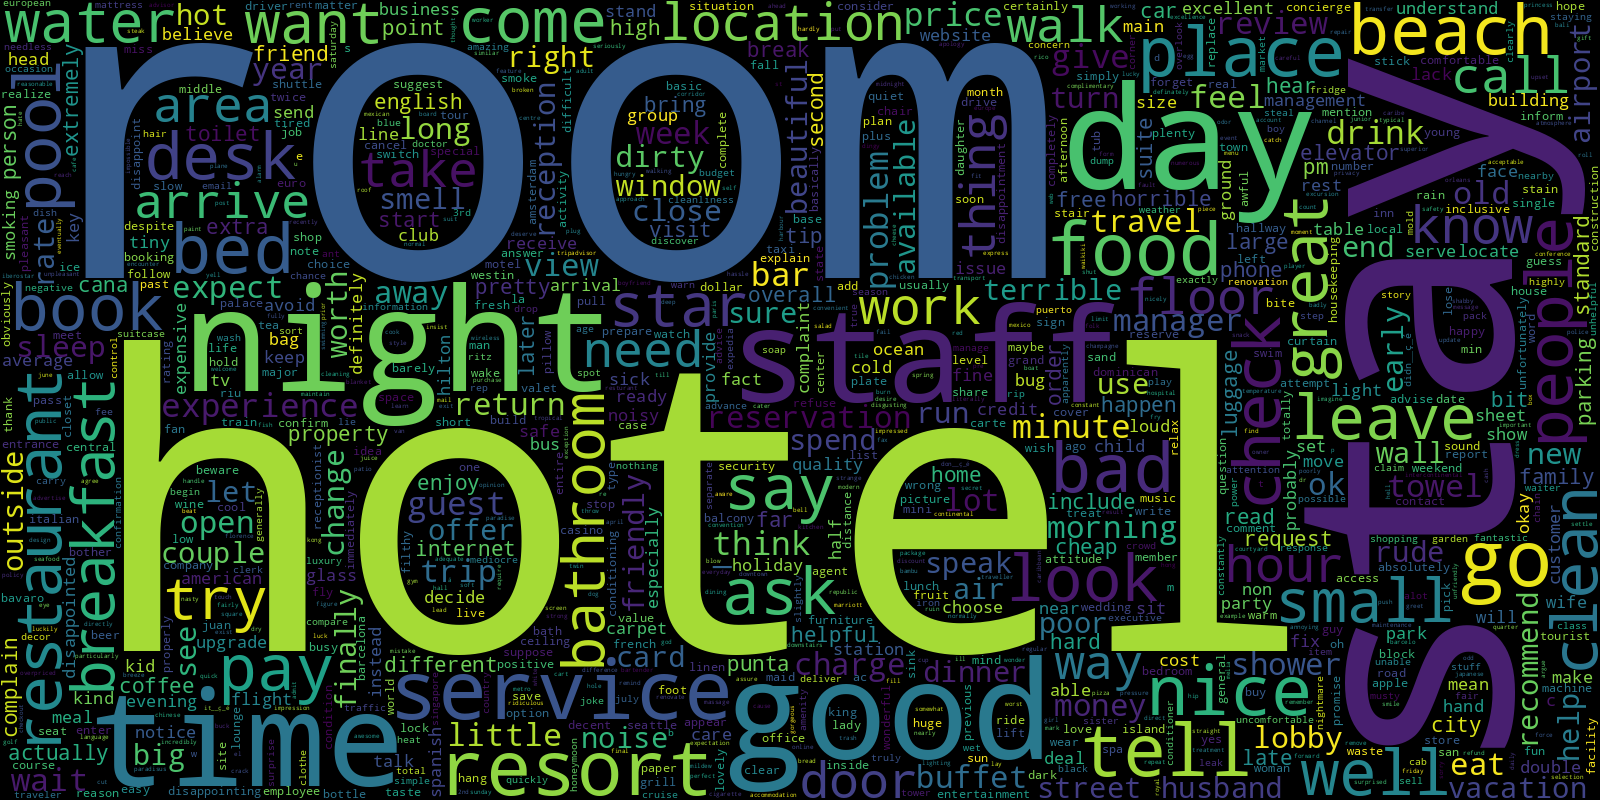

In [16]:
text_neg = ' '.join(data5k[data5k['Rating_class']== 'Negative']['Review'])

wc_neg = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_neg)
wc_neg.to_image()

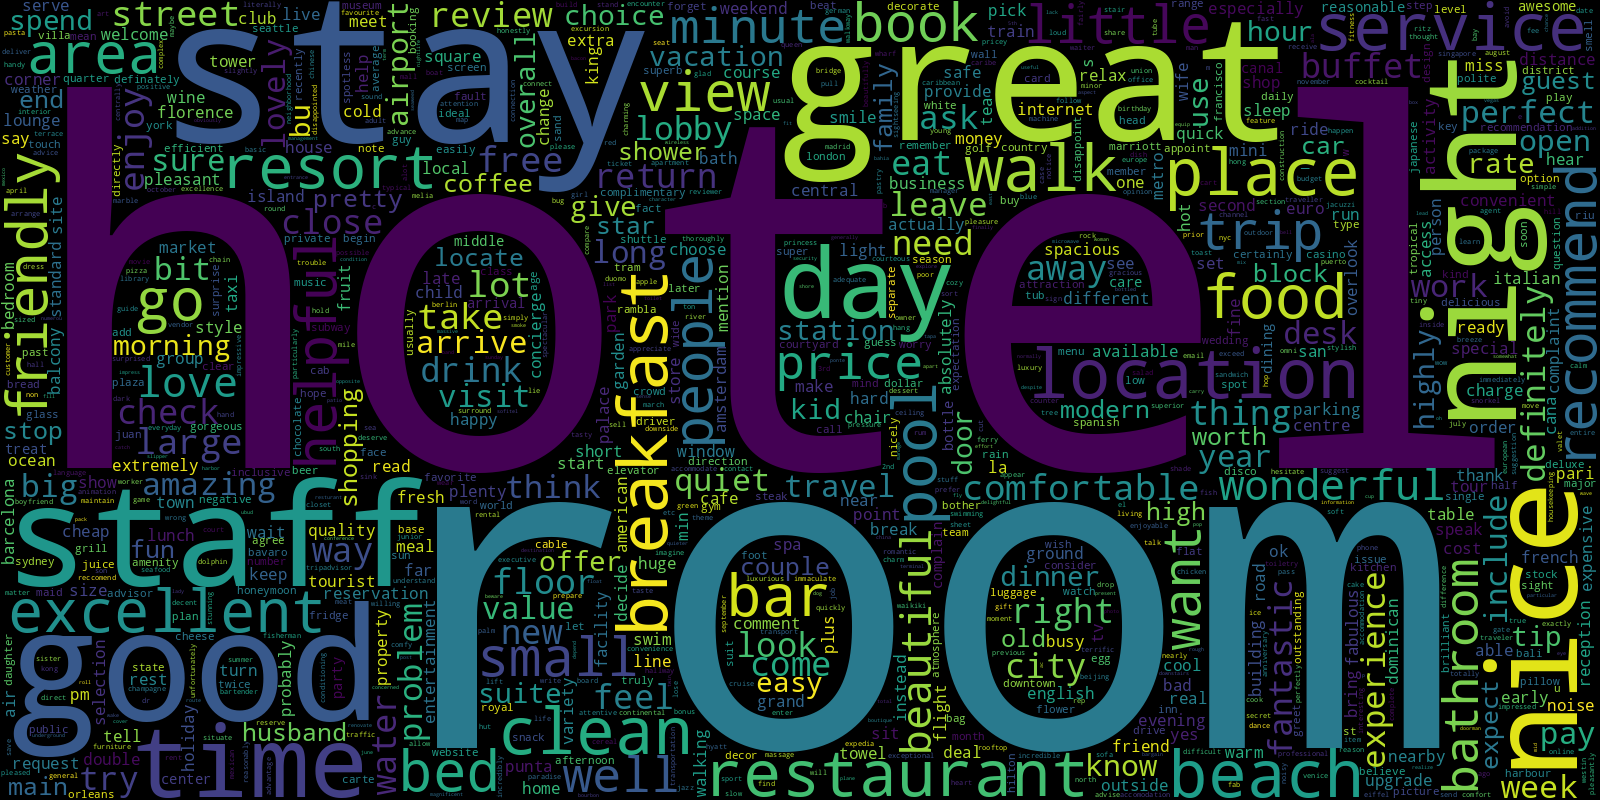

In [17]:
text_pos = ' '.join(data5k[data5k['Rating_class']== 'Positive']['Review'])

wc_pos = WordCloud(max_words = 1000, width = 1600, height = 800, collocations=False).generate(text_pos)
wc_pos.to_image()

In [18]:
# Klasyfikacja

# Metoda train_test_split: 10% test, 90% train

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data5k.Review, data5k.Rating_class, test_size=0.1, stratify=data5k.Rating_class)

In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [21]:
len(vectorizer.get_feature_names_out())

1000

In [22]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [23]:
print(X_train.shape)
print(X_test.shape)

(2700, 1000)
(300, 1000)


In [24]:
model = BernoulliNB()
model.fit(X_train, y_train)

BernoulliNB()

In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.81      0.74      0.77       100
     Neutral       0.61      0.53      0.57       100
    Positive       0.66      0.80      0.72       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



5. Modele treningowe (poszukiwanie optymalnego rozwiązania)

Poniżej prezentuje wyniki analizy na podstawie wcześniej przygotowanych modeli. Załączam modele oraz wykresy obrazujące val_loss i val_accuracy.
Moim celem było znalezienie modelu, dla którego val_accuracy będzie najwyższe przy jednoczesnym jak najniższym val_loss przed epoch, w której dochodzi do przeuczenia modelu.

In [26]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

Model 1 obejmuje jedną wartswę LSTM bez Dropout, najwyższa wartośc val_accuracy występuje w 3 epoch (val_loss: 0.9086 - val_accuracy: 0.5867), po czym występuje przeuczenie modelu.

In [30]:
model = None
r = None

model = load_model('model_single_LSTM.h5')

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1004)]            0         
                                                                 
 embedding (Embedding)       (None, 1004, 20)          328220    
                                                                 
 lstm (LSTM)                 (None, 1004, 128)         76288     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 404895 (1.54 MB)
Trainable params: 404895 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

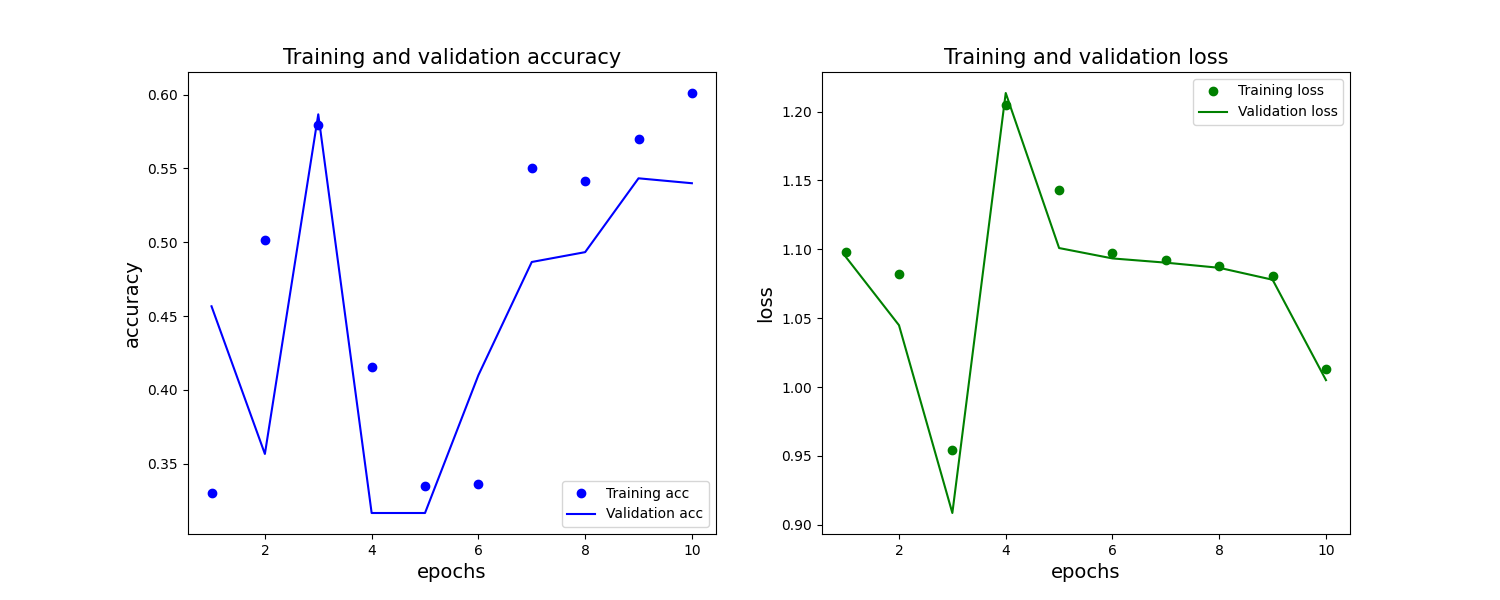

In [35]:
import PIL
from PIL import Image

fp = 'model_single_LSTM.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 2 obejmuje stworzenie 3 warstw LSTM wraz z Dropout, najwyższa wartość val_acuracy występuje w 4 epoch (val_loss: 0.7684 - val_accuracy: 0.6333), następne model sie przeucza.

In [37]:
model = None
r = None

model = load_model('model_3LSTM.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1004)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 1004, 20)          328220    
                                                                 
 lstm_1 (LSTM)               (None, 1004, 128)         76288     
                                                                 
 dropout (Dropout)           (None, 1004, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 1004, 128)         131584    
                                                                 
 dropout_1 (Dropout)         (None, 1004, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 1004, 128)         1315

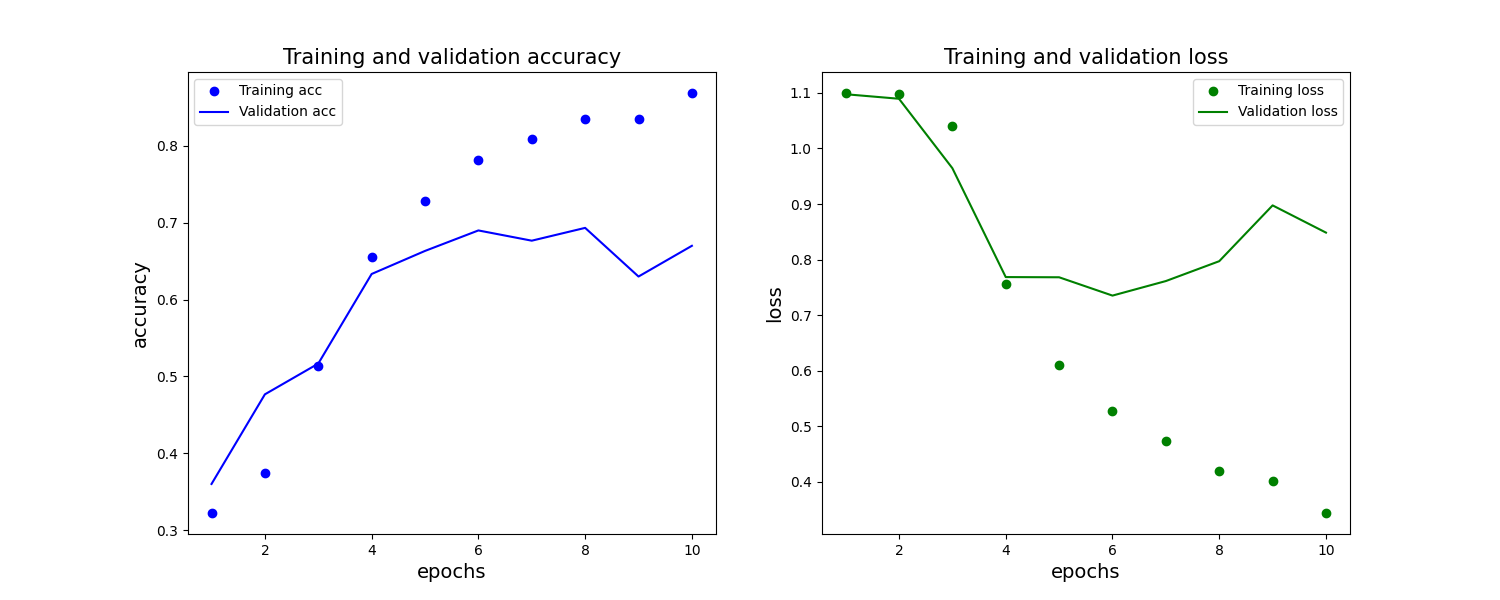

In [38]:
fp = 'model_3LSTM.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 3 to siec dwukierunkowa LSTM z trzema warstwami Bidirectional LSTM oraz Dropout. Wynik działania sieci to val_loss: 0.7353 - val_accuracy: 0.6667 w 3 epoch.

In [40]:
model = None
r = None

model = load_model('model_BiLSTM.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1004)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 1004, 20)          328220    
                                                                 
 bidirectional (Bidirection  (None, 1004, 256)         152576    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1004, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1004, 256)         394240    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1004, 256)         0   

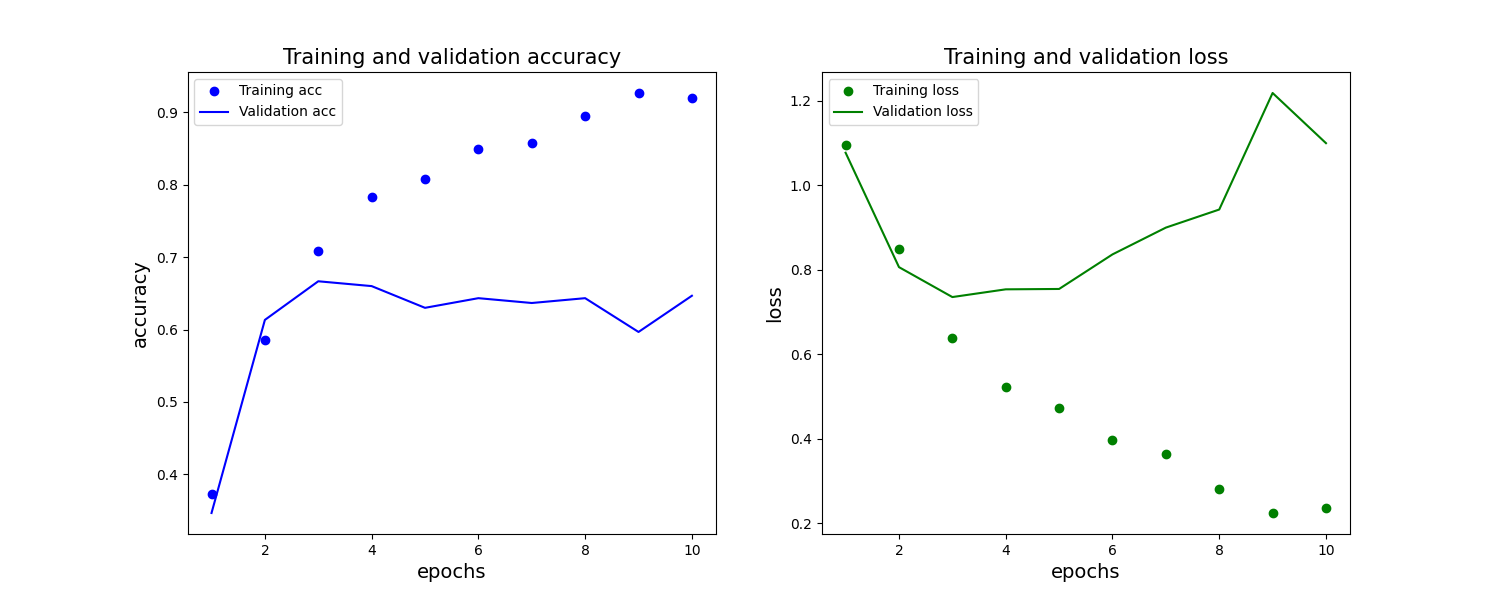

In [41]:
fp = 'model_BiLSTM.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 4 to sieć z pojedynczą warstwą Bidirectional LSTM bez Dropout. Wynikiem działania sieci jest val_loss: 1.0650 - val_accuracy: 0.4800 w epoc 2 oraz val_loss: 0.7564 - val_accuracy: 0.6467 w epoch 6.

In [43]:
model = None
r = None

model = load_model('model_single_BiLSTM.h5')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1004)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1004, 20)          328220    
                                                                 
 bidirectional_3 (Bidirecti  (None, 1004, 256)         152576    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 481567 (1.84 MB)
Trainable params: 481567 (1.

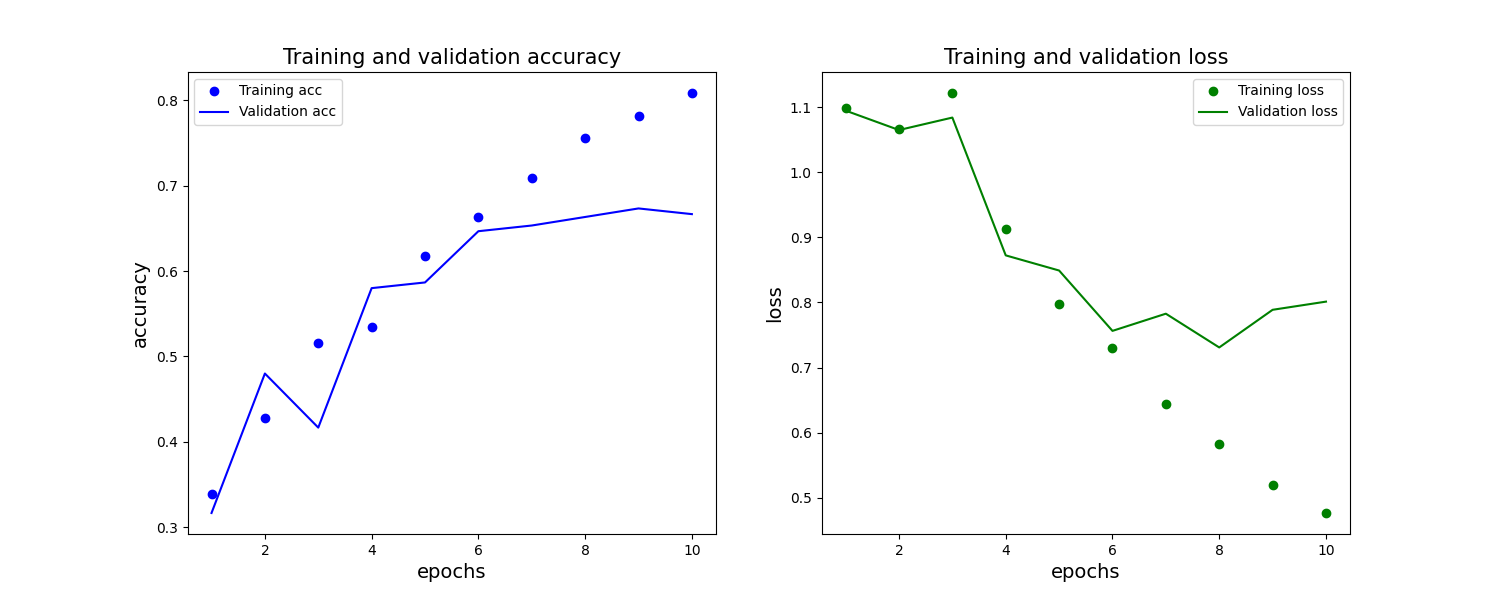

In [44]:
fp = 'model_single_BiLSTM.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Model 5 to sieć z pojedynczą warstwą Bidirectional LSTM z Dropout. Wynikiem działania sieci jest al_loss: 0.9384 - val_accuracy: 0.5867 w epoch 3.

In [46]:
model = None
r = None

model = load_model('model_single_BiLSTM_Dropout.h5')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1004)]            0         
                                                                 
 embedding_4 (Embedding)     (None, 1004, 20)          328220    
                                                                 
 bidirectional_4 (Bidirecti  (None, 1004, 256)         152576    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1004, 256)         0         
                                                                 
 global_max_pooling1d_4 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 3)                 771 

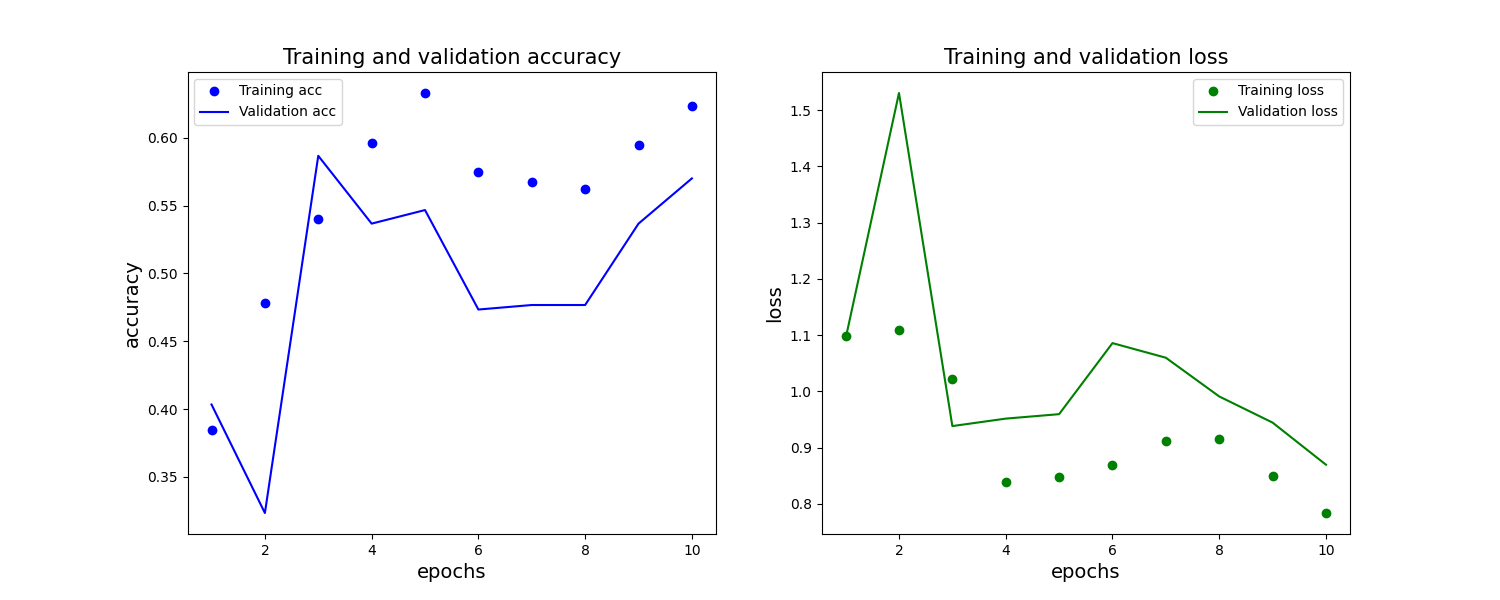

In [47]:
fp = 'model_single_BiLSTM_Dropout.png'
PIL.Image.open(fp, mode='r', formats=None)

In [ ]:
model.get_config()

Podsumowanie modeli

Po przeanalizowaniu 5 wybranych modeli, najniższy wskaźnik val_loss: 0.7353 przy najwyższym val_accuracy: 0.6667 odnotowałam w modelu 3 zawierającym 3 warstwy Bidirectional LSTM wraz z Dropout. Sieć wygląda również na w miarę stabilną, dlatego wybrałam ją do dalszej analizy.

Uwaga: parametry modeli zostały dobrane w taki sposób, aby mogły zostać przeprocesowane przez środowisko wykonawcze google colab. Przy doborze innych parametrów środowisko rozłączało się. Zakładam, że osiągnięte wyniki mogłyby być lepsze dla mocniejszego środowiska.

In [49]:
import plotly.graph_objects as go

6. Praca na modelu

Ponieważ model osiągnął najwyższy wynik na epoch 3, dlatego zawężam jego działanie do tego poziomu. Poniżej przechodze ponownie kroki utworzenia modelu.

Budowa modelu:

model = None

r = None

D = 20



Sposób 1:

---


model = Sequential()

model.add(Embedding(V+1,D))

model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))

model.add(Dropout(0.2))

model.add(GlobalMaxPooling1D())

model.add(Dense(K))

model.summary()

Sposób 2:

---

i = Input(shape = (T,))

x = Embedding(V + 1, D)(i)

x = LSTM(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = LSTM(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = LSTM(128, return_sequences = True, activation='tanh')(x)

x = Dropout(0.2)(x)

x = GlobalMaxPooling1D()(x)

x = Dense(K)(x)


model = Model(i,x)

In [67]:
!pip install -U portalocker>=2.0.0 -q
!pip install torchtext -q

In [68]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def yield_tokens(data_iter):
  for _, text in data_iter:
    yield tokenizer(text)

In [69]:
data5k.head()

,Review,Rating_class
16730,lovely room bali tropic locate lovely beach so...,Positive
16157,fantastic great location right ground easy tra...,Positive
2330,"w great , group 4 girl venture nola celebrate ...",Positive
18997,brilliant great hotel lovely room king size be...,Positive
3575,nice family vacation book annual family vacati...,Positive


In [70]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

data5k['Review'] = data5k['Review'].progress_apply(lemmatize)
data5k.head()

100%|██████████| 3000/3000 [01:12<00:00, 41.24it/s]


,Review,Rating_class
16730,lovely room bali tropic locate lovely beach so...,Positive
16157,fantastic great location right ground easy tra...,Positive
2330,"w great , group 4 girl venture nola celebrate ...",Positive
18997,brilliant great hotel lovely room king size be...,Positive
3575,nice family vacation book annual family vacati...,Positive


In [71]:
data5k['Rating_class'] = data5k['Rating_class'].replace({'Positive':3, 'Neutral':2,
                                                      'Negative': 1})
data5k.head()

,Review,Rating_class
16730,lovely room bali tropic locate lovely beach so...,3
16157,fantastic great location right ground easy tra...,3
2330,"w great , group 4 girl venture nola celebrate ...",3
18997,brilliant great hotel lovely room king size be...,3
3575,nice family vacation book annual family vacati...,3


In [72]:
data5k['targets'] = data5k['Rating_class'].astype("category").cat.codes

In [73]:
# liczba klas

K = data5k['targets'].max()+1
K

3

In [74]:
data_train, data_test = train_test_split(data5k,test_size = 0.1)

In [75]:
data_train.head()

,Review,Rating_class,targets
13096,"fall trap , worth 3.5 star , book hotel hotwir...",1,0
18085,blissfull stay tegal sari like stay time bali ...,3,2
5408,fantastic rome starhotel michelangelo close st...,2,1
4048,"year , get long weekend friend 2 - 5 july stay...",2,1
6271,wait cruise stay night enter royal caribbean c...,2,1


In [76]:
MAX_VOCAB_SIZE = 2000

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_train['Review'])
sequeces_train = tokenizer.texts_to_sequences(data_train['Review'])
sequeces_test = tokenizer.texts_to_sequences(data_test['Review'])

In [77]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Znaleziono %s uniktowych tokenów.'%V)

Znaleziono 16589 uniktowych tokenów.


In [78]:
df_train = pad_sequences(sequeces_train)
print('Kształt tensora treningowego:', df_train.shape)

Kształt tensora treningowego: (2700, 1607)


In [79]:
T = df_train.shape[1]
T

1607

In [80]:
df_test = pad_sequences(sequeces_test, maxlen = T)
print('Kształt tensora treningowego:', df_test.shape)

Kształt tensora treningowego: (300, 1607)


In [81]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Bidirectional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
model = None
r = None
D = 20

model = Sequential()

model.add(Embedding(V+1,D))
model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences = True, activation='tanh')))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(K))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          331800    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         152576    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 256)         394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         3

In [83]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model single LSTM ...')

r = model.fit(
    df_train,
    data_train['targets'],
    epochs = 3,
    batch_size = 128,
    validation_data = (df_test, data_test['targets'])
)

Training model single LSTM ...
Epoch 1/3
22/22 [==============================] - 1023s 43s/step - loss: 1.0981 - accuracy: 0.3352 - val_loss: 1.0819 - val_accuracy: 0.3233
Epoch 2/3
22/22 [==============================] - 929s 42s/step - loss: 0.9008 - accuracy: 0.5489 - val_loss: 0.8003 - val_accuracy: 0.6100
Epoch 3/3
22/22 [==============================] - 947s 43s/step - loss: 0.7068 - accuracy: 0.6822 - val_loss: 0.7152 - val_accuracy: 0.7067


In [84]:
def plot_loss_accuracy(r):


  acc = r.history['accuracy']
  val_acc = r.history['val_accuracy']
  loss = r.history['loss']
  val_loss = r.history['val_loss']


  epochs = range(1 ,len(acc) + 1)


  plt.figure(figsize=(15,6))

  plt.subplot(121)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title("Training and validation accuracy", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("accuracy", fontsize=14)
  plt.legend()

  plt.subplot(122)
  plt.plot(epochs, loss, 'go', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title("Training and validation loss", fontsize=15)
  plt.xlabel('epochs', fontsize=14)
  plt.ylabel("loss", fontsize=14)
  plt.legend()

  plt.savefig("model_LSTM_final.png")

  plt.show()

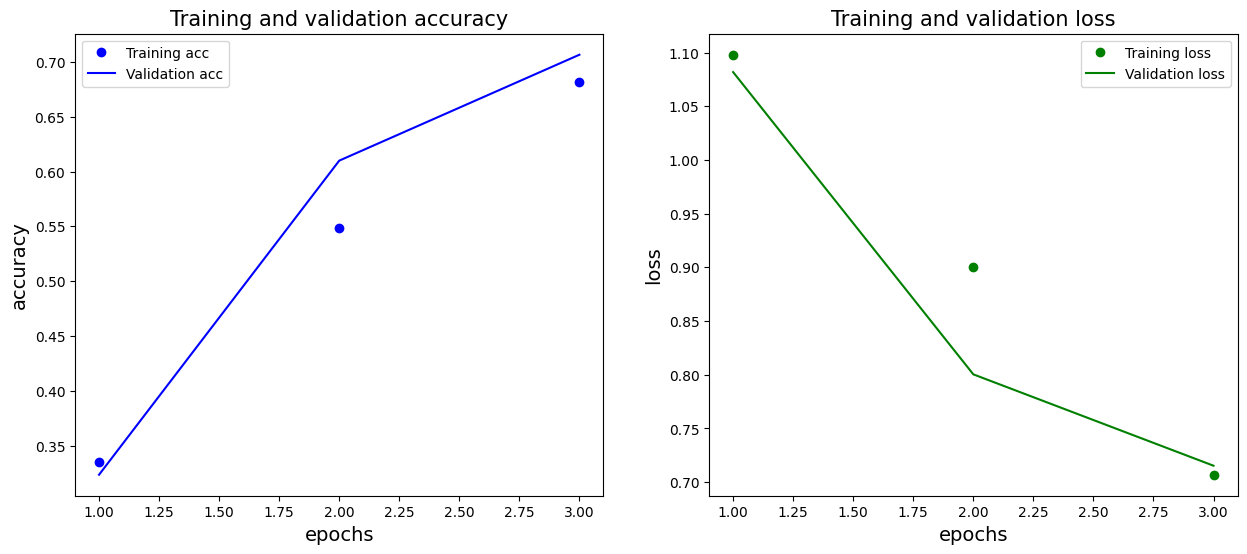

In [85]:
plot_loss_accuracy(r)

In [86]:
model.save('model_LSTM_final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
model.get_config()

In [89]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = None
r = None

model = load_model('model_LSTM_final.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          331800    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         152576    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 256)         394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         3

7. Analiza sentymentu

In [90]:
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [91]:
data5k.rename(columns={'targets':'label'}, inplace=True)
data5k.rename(columns={'Review':'text'}, inplace=True)
del data5k['Rating_class']
data5k.sample(3)

,text,label
9594,"particularly outstanding , give review site ex...",0
12228,extremely luxurious location westin extremely ...,2
12156,"great hotel definitely recommend stay hotel , ...",2


In [92]:
from datasets import Dataset
dataset_ = Dataset.from_pandas(data5k)
dataset = dataset_.train_test_split(0.1)

In [93]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 2700
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 300
    })
})


In [94]:
model_checkpoint = 'microsoft/deberta-base'
batch_size = 128

In [95]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [96]:
tokenizer('recommend hotel reviewer actually stay hotel')

{'input_ids': [1, 43140, 1397, 2303, 37102, 888, 1095, 2303, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [97]:
def process(x):
  return tokenizer(x['text'])

train_ds = dataset['train'].map(process)
eval_ds = dataset['test'].map(process)

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (797 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [98]:
train_ds

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2700
})

In [99]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
!pip install -U accelerate==0.20.1 -q
#!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 2.8 MB/s eta 0:00:00


In [101]:
import transformers
#!pip install -qqq torch==2.0.1 --progress-bar off
#import accelerate 0.20.1

In [102]:
transformers.__version__, accelerate.__version__

('4.35.2', '0.20.3')

In [103]:
args = TrainingArguments(
    f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy  = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    num_train_epochs  = 5,
    weight_decay  = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy'
)

In [104]:
from datasets import load_metric
import numpy as np

metric = load_metric('glue','sst2')

def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis = 1)
  return metric.compute(predictions = predictions, references = labels)

<ipython-input-104-211fb054b740>:4: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning:

The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.



In [105]:
trainer = Trainer(
    model,
    args,
    train_dataset  = train_ds,
    eval_dataset = eval_ds,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [ ]:
trainer.evaluate([train_ds[0]])

In [ ]:
trainer.train()

In [107]:
%load_ext tensorboard

In [108]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/demo')

In [109]:
trainer.model

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

In [118]:
data5k

,text,label
16730,lovely room bali tropic locate lovely beach so...,2
16157,fantastic great location right ground easy tra...,2
2330,"w great , group 4 girl venture nola celebrate ...",2
18997,brilliant great hotel lovely room king size be...,2
3575,nice family vacation book annual family vacati...,2
...,...,...
2738,"nice beach terrible food , sick wife go 3 coup...",0
14185,5 star price half star service place clean bea...,0
11355,damn hotel stay fairly cheap accommodation pre...,0
11049,"need little help , exchange 5 star timeshare s...",0


In [120]:
import torch

text = data5k['text'].loc[14185]
inputs = tokenizer(text, return_tensors='pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)
  logits = outputs.logits
  predictions = torch.argmax(logits, dim=-1)

if predictions.item() == 0:
  print("negative example")
elif predictions.item() == 1:
  print("neutral example")
else:
  print("positive example")

neutral example


In [121]:
data5k['text'].loc[14185]

'5 star price half star service place clean beautiful service unbelievably bad , day room ready 5:30 pm , wait room wait hour 20 minute 2 hamburger pool restaurant , let bring food restaurant awful food bad service ridiculous price , 9 bottle water , mini bar , strongly suspect calamari asian fusion restaurant fry rubber band , sampler platter suppose include grill chicken beef shrimp eggplant plate chicken bite beef waiter care screw , staff zoom property day night loud gasoline power golf cart sound like parade lawn mower , charge 70 pick airport 85 drop old san juan 20 minute ride , ice machine towel , car rental desk charge twice rest puerto rico do , gran melia make extra money let non guest pay use pool place crawl kid day , feel like go great length squeeze dollar effort deliver passable service , travel lot mind pay nice place charge 5 star price give half star service , nearly ruin honeymoon , puerto rico great stay away gran melia ,'

In [122]:
data.iloc[14185]

Review          5 star prices half star service place clean be...
Rating_class                                             Negative
Name: 14185, dtype: object

8. Podsumowanie

Podczas analizy skupiłam sie na znalezieniu optymalnego modelu, który umożliwiłby poprawną klasyfikację sentymentu dotyczącego przekazanych opinii.

Spośród 5 stworzonych modeli wybrałam jeden, którego dokadność jest na poziomie val_accuracy: 0.7067 a strata na poziomie val_loss: 0.7152. Jest to model BiLSTM, dla którego najlepszy wynik osiągnęłam w 4 epoce. w dalszym działaniu modelu dochodziło do jego przeuczenia.

Model w porównniu z modelem BiGRU osiągnął lepsze wyniki, dlatego podczas tworzenia modelu do wykorzystania biznesowego wybrałabym właśnie ten model jako model bazowy do dalszego testowania. Oczywiście można jeszcze powalczyć o osiągnięcie wyższej dokładności, jednak na chwilę obecną na tym kończę analizę.
